In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import VGG16
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

In [ ]:
# PARAMETERS
IMG_SIZE = 256
NUM_CLASSES = 4
BATCH_SIZE = 8
EPOCHS = 15

# PATHS
BASE_PATH = "C:\\Users\\Administrator\\Downloads\\RTK\\RTK"
IMAGE_DIR = os.path.join(BASE_PATH, "image")
LABEL_DIR = os.path.join(BASE_PATH, "label")
LABEL_MAP = {1: 0, 2: 1, 3: 2, 4: 3}

In [ ]:
# Load file lists
with open(os.path.join(BASE_PATH, "trainpaths.txt")) as f:
    train_files = [os.path.basename(x.strip()) for x in f.readlines()]
with open(os.path.join(BASE_PATH, "valpaths.txt")) as f:
    val_files = [os.path.basename(x.strip()) for x in f.readlines()]

In [ ]:
# Preprocessing

def preprocess_image(image_path, label_path):
    image = cv2.imread(image_path)
    image = cv2.resize(image, (IMG_SIZE, IMG_SIZE)) / 255.0
    mask = cv2.imread(label_path, cv2.IMREAD_GRAYSCALE)
    mask = cv2.resize(mask, (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_NEAREST)
    remapped = np.zeros_like(mask)
    for raw, new in LABEL_MAP.items():
        remapped[mask == raw] = new
    return image, remapped
def augment(img, mask):
    if np.random.rand() > 0.5:
        img = np.fliplr(img)
        mask = np.fliplr(mask)
    if np.random.rand() > 0.5:
        img = np.flipud(img)
        mask = np.flipud(mask)
    return img, mask

def load_dataset(file_list, augment_flag=False):
    images, masks = [], []
    for fname in file_list:
        img_path = os.path.join(IMAGE_DIR, fname)
        mask_path = os.path.join(LABEL_DIR, fname)
        if os.path.exists(img_path) and os.path.exists(mask_path):
            img, msk = preprocess_image(img_path, mask_path)
            if augment_flag:
                img, msk = augment(img, msk)
            images.append(img)
            masks.append(msk)
    return np.array(images), tf.keras.utils.to_categorical(np.array(masks), NUM_CLASSES)

In [ ]:
# Load data
x_train, y_train = load_dataset(train_files, augment_flag=True)
x_val, y_val = load_dataset(val_files)

print("Train size:", x_train.shape)
print("Val size:", x_val.shape)

Train size: (561, 256, 256, 3)
Val size: (140, 256, 256, 3)


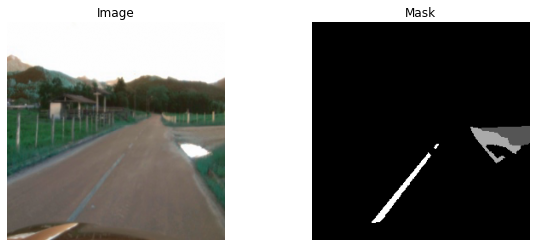

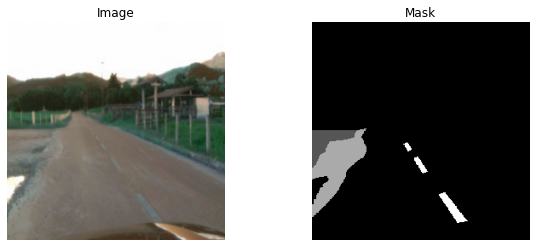

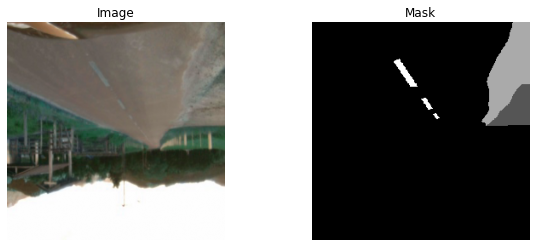

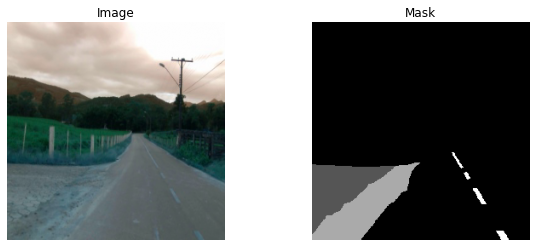

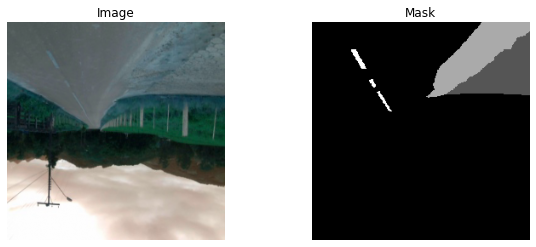

In [ ]:
def preview_data(images, masks, n=3):
    for i in range(n):
        plt.figure(figsize=(10, 4))
        plt.subplot(1, 2, 1)
        plt.imshow(images[i])
        plt.title("Image")
        plt.axis("off")

        plt.subplot(1, 2, 2)
        plt.imshow(np.argmax(masks[i], axis=-1), cmap="gray")
        plt.title("Mask")
        plt.axis("off")
        plt.show()

# Then run:
preview_data(x_train, y_train, n=5)

In [ ]:
# IoU Metric

def mean_iou(y_true, y_pred):
    y_true = tf.argmax(y_true, axis=-1)
    y_pred = tf.argmax(y_pred, axis=-1)
    ious = []
    for i in range(NUM_CLASSES):
        inter = tf.reduce_sum(tf.cast((y_true == i) & (y_pred == i), tf.float32))
        union = tf.reduce_sum(tf.cast((y_true == i) | (y_pred == i), tf.float32))
        iou = inter / (union + 1e-7)
        ious.append(iou)
    return tf.reduce_mean(ious)

In [ ]:
# Build U-Net with VGG16 encoder

def build_unet_vgg(input_shape=(IMG_SIZE, IMG_SIZE, 3)):
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = False

    inputs = keras.Input(shape=input_shape)
    x = inputs

    skips = [
        base_model.get_layer("block1_conv2").output,
        base_model.get_layer("block2_conv2").output,
        base_model.get_layer("block3_conv3").output,
        base_model.get_layer("block4_conv3").output,
    ]

    encoder = keras.Model(inputs=base_model.input, outputs=skips)
    encoder_outputs = encoder(x)

    b = base_model.get_layer("block5_conv3").output

    # Decoder
    u4 = layers.UpSampling2D()(b)
    u4 = layers.Concatenate()([u4, skips[3]])
    c4 = layers.Conv2D(256, 3, activation='relu', padding='same')(u4)
    c4 = layers.Conv2D(256, 3, activation='relu', padding='same')(c4)

    u3 = layers.UpSampling2D()(c4)
    u3 = layers.Concatenate()([u3, skips[2]])
    c3 = layers.Conv2D(128, 3, activation='relu', padding='same')(u3)
    c3 = layers.Conv2D(128, 3, activation='relu', padding='same')(c3)

    u2 = layers.UpSampling2D()(c3)
    u2 = layers.Concatenate()([u2, skips[1]])
    c2 = layers.Conv2D(64, 3, activation='relu', padding='same')(u2)
    c2 = layers.Conv2D(64, 3, activation='relu', padding='same')(c2)

    u1 = layers.UpSampling2D()(c2)
    u1 = layers.Concatenate()([u1, skips[0]])
    c1 = layers.Conv2D(32, 3, activation='relu', padding='same')(u1)
    c1 = layers.Conv2D(32, 3, activation='relu', padding='same')(c1)

    outputs = layers.Conv2D(NUM_CLASSES, 1, activation='softmax')(c1)

    model = keras.Model(inputs=base_model.input, outputs=outputs)
    return model

In [ ]:
# Compile & Train
model = build_unet_vgg()
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy", mean_iou])
model.summary()

callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True),
    ReduceLROnPlateau(factor=0.5, patience=3),
    ModelCheckpoint("unet_vgg_best.h5", save_best_only=True)
]

history = model.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=callbacks
)

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 256, 256, 64  1792        ['input_5[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv2 (Conv2D)          (None, 256, 256, 64  36928       ['block1_conv1[0][0]']           
                                )                                                           

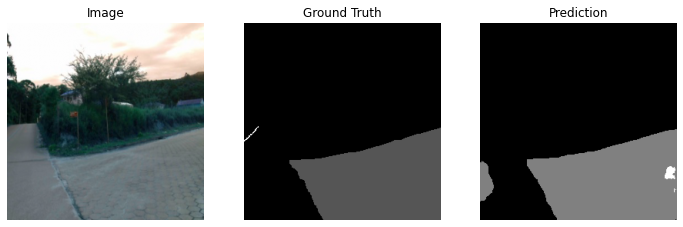

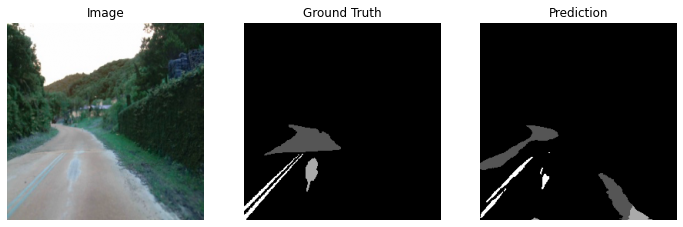

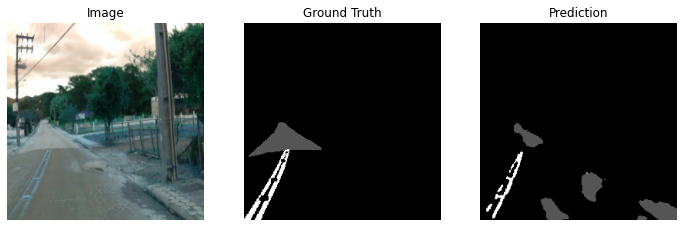

In [ ]:
# Visualize Predictions

def visualize_predictions(n=3):
    indices = np.random.choice(len(x_val), n, replace=False)
    preds = model.predict(x_val[indices])
    for i in range(n):
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 3, 1)
        plt.imshow(x_val[indices[i]])
        plt.title("Image")
        plt.axis("off")
        plt.subplot(1, 3, 2)
        plt.imshow(np.argmax(y_val[indices[i]], axis=-1), cmap="gray")
        plt.title("Ground Truth")
        plt.axis("off")
        plt.subplot(1, 3, 3)
        plt.imshow(np.argmax(preds[i], axis=-1), cmap="gray")
        plt.title("Prediction")
        plt.axis("off")
        plt.show()

visualize_predictions()